In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [2]:
def load_iris_data():
    # Load bộ dữ liệu Wine
    wine = load_wine()

    # Chuyển đổi dữ liệu thành DataFrame
    df = pd.DataFrame(data=np.c_[wine['data'], wine['target']],
                     columns=wine['feature_names'] + ['target'])

    return df, wine['feature_names']

In [3]:
def prepare_multivariate_data(df, target_index=0, scale=True):
  """
    Chuẩn bị dữ liệu cho mô hình hồi quy đa biến

    Tại sao cần chuẩn hóa dữ liệu (StandardScaler)?

    1. Đồng nhất hóa phạm vi giá trị:
       - Các đặc trưng trong bộ Wine có giá trị khác nhau rất lớn 
       - Ví dụ: alcohol (11–14) vs flavanoids (0–5)
       - Chuẩn hóa giúp đưa tất cả về mean=0 và std=1

    2. Cải thiện quá trình tối ưu với Gradient Descent:
       - Các feature không đồng nhất làm mô hình học kém hiệu quả
       - Chuẩn hóa giúp gradient đồng đều hơn  
       → Mô hình hội tụ nhanh hơn và ổn định hơn.

    3. Giúp so sánh hệ số công bằng:
       - Sau chuẩn hóa, hệ số lớn hơn nghĩa là đặc trưng quan trọng hơn.

    Params:
        df (DataFrame)
        target_index (int): đặc trưng cần dự đoán
        scale (bool)
    """

  # Tách features (X) và target (y)
  features = df.iloc[:, [i for i in range(len(df.columns)-1) if i != target_index]]

  # In thông tin về phạm vi giá trị trước chuẩn hóa
  print("\nPhạm vi giá trị của các đặc trưng trước khi chuẩn hóa:")
  for column in features.columns:
      print(f"{column}:")
      print(f"  - Min: {features[column].min():.2f}")
      print(f"  - Max: {features[column].max():.2f}")
      print(f"  - Mean: {features[column].mean():.2f}")
      print(f"  - Std: {features[column].std():.2f}")

  target = df.iloc[:, target_index]

  X_train, X_test, y_train, y_test = train_test_split(
      features, target, test_size=0.2, random_state=42
  )

  if scale:
      scaler = StandardScaler()
      X_train = scaler.fit_transform(X_train)
      X_test = scaler.transform(X_test)

      X_train = pd.DataFrame(X_train, columns=features.columns)
      X_test = pd.DataFrame(X_test, columns=features.columns)

      print("\nPhạm vi giá trị sau khi chuẩn hóa (tập train):")
      for column in X_train.columns:
          print(f"{column}:")
          print(f"  - Min: {X_train[column].min():.2f}")
          print(f"  - Max: {X_train[column].max():.2f}")
          print(f"  - Mean: {X_train[column].mean():.2f}")
          print(f"  - Std: {X_train[column].std():.2f}")

      plt.figure(figsize=(15, 5))

      plt.subplot(1, 2, 1)
      features.boxplot()
      plt.title('Phân phối trước khi chuẩn hóa')
      plt.xticks(rotation=45)

      plt.subplot(1, 2, 2)
      X_train.boxplot()
      plt.title('Phân phối sau khi chuẩn hóa')
      plt.xticks(rotation=45)

      plt.tight_layout()
      plt.show()

  return X_train, X_test, y_train, y_test

In [4]:
def train_multivariate_model(X_train, X_test, y_train, y_test, feature_names, target_name):
    # Khởi tạo và huấn luyện mô hình
    model = LinearRegression()
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    print(f"\nKết quả hồi quy đa biến cho {target_name}")
    print("\nHệ số hồi quy:")
    for name, coef in zip(feature_names, model.coef_):
        print(f"{name}: {coef:.4f}")
    print(f"Hệ số tự do (w0): {model.intercept_:.4f}")

    print(f"\nMetrics đánh giá:")
    print(f"Train MSE: {train_mse:.4f}")
    print(f"Test MSE: {test_mse:.4f}")
    print(f"Train R2 Score: {train_r2:.4f}")
    print(f"Test R2 Score: {test_r2:.4f}")

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(y_train, y_train_pred, color='blue')
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
    plt.xlabel('Giá trị thực tế')
    plt.ylabel('Giá trị dự đoán')
    plt.title('Tập huấn luyện')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_test_pred, color='blue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Giá trị thực tế')
    plt.ylabel('Giá trị dự đoán')
    plt.title('Tập kiểm tra')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Absolute Coefficient': np.abs(model.coef_)
    })
    feature_importance = feature_importance.sort_values('Absolute Coefficient', ascending=False)

    plt.figure(figsize=(10, 5))
    plt.bar(feature_importance['Feature'], feature_importance['Absolute Coefficient'])
    plt.xticks(rotation=45)
    plt.xlabel('Đặc trưng')
    plt.ylabel('Độ lớn hệ số hồi quy')
    plt.title('Tầm quan trọng của các đặc trưng')
    plt.tight_layout()
    plt.show()

    return model


Phạm vi giá trị của các đặc trưng trước khi chuẩn hóa:
malic_acid:
  - Min: 0.74
  - Max: 5.80
  - Mean: 2.34
  - Std: 1.12
ash:
  - Min: 1.36
  - Max: 3.23
  - Mean: 2.37
  - Std: 0.27
alcalinity_of_ash:
  - Min: 10.60
  - Max: 30.00
  - Mean: 19.49
  - Std: 3.34
magnesium:
  - Min: 70.00
  - Max: 162.00
  - Mean: 99.74
  - Std: 14.28
total_phenols:
  - Min: 0.98
  - Max: 3.88
  - Mean: 2.30
  - Std: 0.63
flavanoids:
  - Min: 0.34
  - Max: 5.08
  - Mean: 2.03
  - Std: 1.00
nonflavanoid_phenols:
  - Min: 0.13
  - Max: 0.66
  - Mean: 0.36
  - Std: 0.12
proanthocyanins:
  - Min: 0.41
  - Max: 3.58
  - Mean: 1.59
  - Std: 0.57
color_intensity:
  - Min: 1.28
  - Max: 13.00
  - Mean: 5.06
  - Std: 2.32
hue:
  - Min: 0.48
  - Max: 1.71
  - Mean: 0.96
  - Std: 0.23
od280/od315_of_diluted_wines:
  - Min: 1.27
  - Max: 4.00
  - Mean: 2.61
  - Std: 0.71
proline:
  - Min: 278.00
  - Max: 1680.00
  - Mean: 746.89
  - Std: 314.91

Phạm vi giá trị sau khi chuẩn hóa (tập train):
malic_acid:
  - Min:

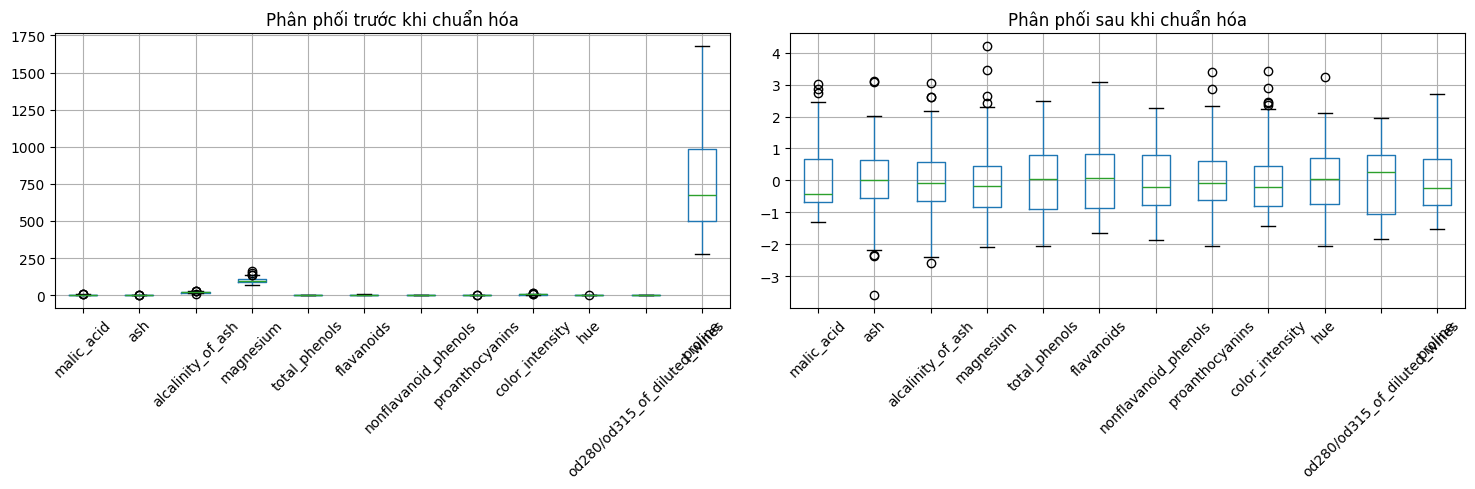


Kết quả hồi quy đa biến cho alcohol

Hệ số hồi quy:
malic_acid: 0.1287
ash: 0.0747
alcalinity_of_ash: -0.1613
magnesium: -0.0263
total_phenols: 0.0584
flavanoids: -0.0108
nonflavanoid_phenols: -0.0159
proanthocyanins: -0.0830
color_intensity: 0.3943
hue: 0.0942
od280/od315_of_diluted_wines: 0.0859
proline: 0.2983
Hệ số tự do (w0): 12.9791

Metrics đánh giá:
Train MSE: 0.2912
Test MSE: 0.1857
Train R2 Score: 0.5640
Test R2 Score: 0.6889


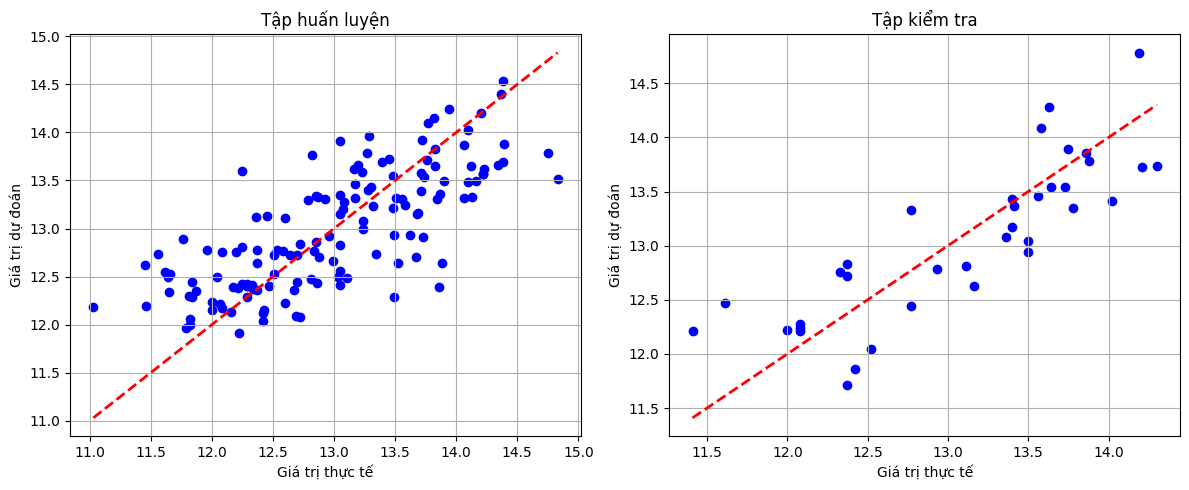

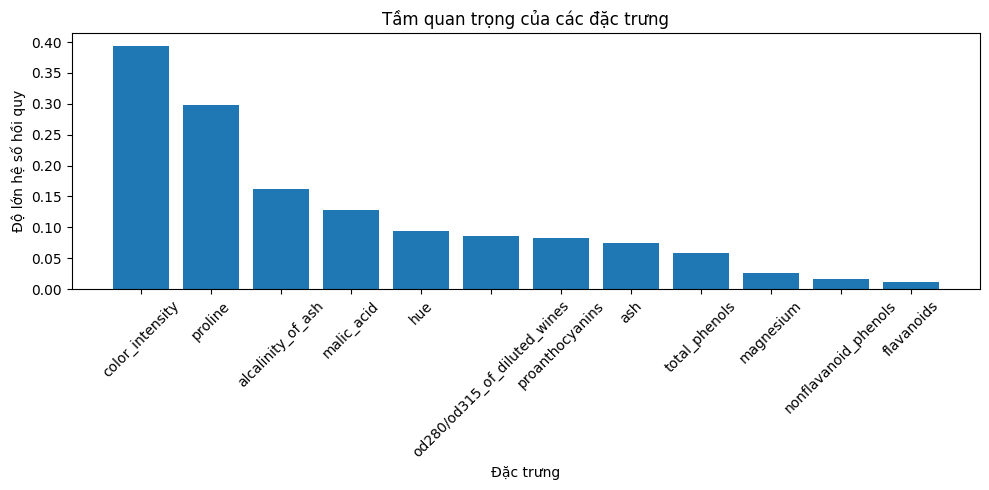


Demo dự đoán:
Đầu vào: {'malic_acid': np.float64(0.6373187412153807), 'ash': np.float64(0.7157857907062193), 'alcalinity_of_ash': np.float64(-1.241280355132674), 'magnesium': np.float64(1.0655672175876452), 'total_phenols': np.float64(0.6466366889064011), 'flavanoids': np.float64(1.027242366854435), 'nonflavanoid_phenols': np.float64(-1.549320936237817), 'proanthocyanins': np.float64(0.08936052953773631), 'color_intensity': np.float64(0.01825222796978623), 'hue': np.float64(0.015516948246124351), 'od280/od315_of_diluted_wines': np.float64(1.0661342138680752), 'proline': np.float64(0.36548715111247965)}
Dự đoán alcohol: 13.54


c:\Users\PC\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [5]:
df, feature_names = load_iris_data()

# Chọn một đặc trưng làm target (ví dụ: alcohol)
target_index = 0
target_name = feature_names[target_index]

# Chuẩn bị dữ liệu
X_train, X_test, y_train, y_test = prepare_multivariate_data(
    df, target_index=target_index, scale=True
)

# Lấy tên các đặc trưng đầu vào
input_features = [name for i, name in enumerate(feature_names) if i != target_index]

# Huấn luyện mô hình
model = train_multivariate_model(
    X_train, X_test, y_train, y_test,
    input_features, target_name
)

# Demo dự đoán
print("\nDemo dự đoán:")
sample_input = X_test.iloc[0]
print("Đầu vào:", dict(sample_input))
prediction = model.predict([sample_input])[0]
print(f"Dự đoán {target_name}: {prediction:.2f}")